# Python程式設計：xarray與氣候分析

`xarray`是由The Climate Corporation的科學家Stephan Hoyer、Alex Kleeman、Eugene Brevdo開發的工具，2014年以開放取用資源的方式釋出，2018年起由NumFOCUS贊助。這套工具專門為多維陣列的資料所設計，用以讀取netCDF資料、進行資料處理、範圍選取、統計運算和繪圖，並且把這些功能整合在一起，使得工作流程變得簡潔流暢。

在大氣科學研究中，我們常用的程式邏輯就是
* 讀取資料
* 統計與分析
* 模式模擬
* 視覺化

![](https://d33wubrfki0l68.cloudfront.net/795c039ba2520455d833b4034befc8cf360a70ba/558a5/diagrams/data-science-explore.png)
Source: Grolemund and Wickham (2016), *R For Data Science*.

因此，本文將按照以上邏輯，以`xarray`函式庫為主要資料處理、統計計算和繪圖的核心，以氣候分析的角度介紹常使用的Python函式庫以及程式技巧，以建立資料分析流程。本文的目的不在建立一個嚴謹的`xarray`使用說明，而是從氣候分析的實例出發，說明`xarray`的用法，因此若需要函數或引數的相關細節，請參見[`xarray`網頁](http://xarray.pydata.org/en/stable/index.html#)。

**小提示：** 如果對Python的基本指令還不熟悉 (e.g. 變數種類、變數定義、if分支結構、for迴圈、函數/副程式⋯⋯等)，可以先上網站搜尋入門教學，再來學習本文的內容喔！(例如：[一小時Python入門網頁](https://kopu.chat/2017/01/18/%E4%B8%80%E5%B0%8F%E6%99%82python%E5%85%A5%E9%96%80-part-1/)，其實網路上資源非常多也容易讀)

安裝函式庫
---
在本文中，需要的函式庫有 `numpy`、`xarray`、`pandas`、`matplotlib`......等，如果電腦中還沒有安裝這些套件，建議可以利用Anaconda安裝。
接著在空白的Python程式 (副檔名.py) 加入以下指令，就可以引入所需要的資源庫。以下為本文會使用的函式庫：

In [1]:
import numpy as np
import pandas as pd 
from datetime import datetime
import xarray as xr 
import cartopy.crs as ccrs   
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from matplotlib import pyplot as plt
import cmaps 

讀取netCDF資料
---
- **讀取單一netCDF檔案：**`xarray.open_dataset(filename)`。以讀取CMORPH降雨資料為例：

In [2]:
olr = xr.open_dataset("data/olr.nc")
olr

<xarray.Dataset>
Dimensions:   (time: 8395, lon: 170, bnds: 2, lat: 50)
Coordinates:
  * time      (time) datetime64[ns] 1998-01-01 1998-01-02 ... 2020-12-31
  * lon       (lon) float32 40.5 41.5 42.5 43.5 44.5 ... 206.5 207.5 208.5 209.5
  * lat       (lat) float32 -19.5 -18.5 -17.5 -16.5 ... 26.5 27.5 28.5 29.5
Dimensions without coordinates: bnds
Data variables:
    lon_bnds  (lon, bnds) float32 ...
    lat_bnds  (lat, bnds) float32 ...
    olr       (time, lat, lon) float32 ...
Attributes: (12/49)
    CDI:                        Climate Data Interface version 1.9.10 (https:...
    Conventions:                CF-1.6
    source:                     NOAA Archive of HIRS L1B data from TIROS-N Se...
    institution:                UMD/ESSIC > Earth System Science Interdiscipl...
    history:                    Wed Dec 22 12:33:17 2021: cdo sellonlatbox,40...
    conventions:                CF-1.6
    ...                         ...
    Metadata_Link:              gov.noaa.ncdc:C00875
    product_version:            Ver01Rev02
    platform:                   TIROS-N > Television Infrared Observation Sat...
    sensor:                     HIRS-2 > High Resolution Infra-red Sounder/2,...
    spatial_resolution:         1.0 by 1.0 degree equal angle
    CDO:                        Climate Data Operators version 1.9.10 (https:...

利用`xarray`開啟檔案，時間格式會自動轉化為`datetime64`；若變數的格式是壓縮的`short`，xarray會將其轉化(decode)為`float32`。

- **讀取多個netCDF檔案 (Reading Multiple Files)：** `xarray.open_mfdataset(paths)`，其中`combine`引數有分為`"by_coords"`、`"nested"`兩種，其中`by_coords`是沿著某一個座標軸連接，而`nested`則是另創新的座標軸將資料連接在一起。

  **Example 1 沿座標軸合併：** 

繪圖基礎：畫等值地圖 (Contour maps)
--- 
首先用最簡單的方式，示範以`xarray`讀取netCDF格式資料、簡易運算和繪製等值地圖的過程。

**Example 4 區域2017年12月平均外逸長波輻射 (outgoing longwave radiation, OLR)：** 繪製這個圖會經過幾個步驟
1. 開啟檔案。
2. 選取特定時空範圍。
3. 時間平均。
4. 繪圖。

In [3]:
# 選擇資料的時空範圍。
lats = -25
latn = 26
lon1 =  79 
lon2 = 161
time1 = '2017-12-01'
time2 = '2017-12-31'

# 開啟檔案
with xr.open_dataset("data/olr.nc") as olr_ds:   # with...as 使得dataset讀完就把檔案關起來，不佔記憶體。
     olr = (olr_ds.sel(time=slice(time1,time2),
                       lat=slice(lats,latn),
                       lon=slice(lon1,lon2)).olr)    # 將olr從Dataset中讀出來，成為一個DataArray

print(olr)

<xarray.DataArray 'olr' (time: 31, lat: 46, lon: 82)>
[116932 values with dtype=float32]
Coordinates:
  * time     (time) datetime64[ns] 2017-12-01 2017-12-02 ... 2017-12-31
  * lon      (lon) float32 79.5 80.5 81.5 82.5 83.5 ... 157.5 158.5 159.5 160.5
  * lat      (lat) float32 -19.5 -18.5 -17.5 -16.5 -15.5 ... 22.5 23.5 24.5 25.5
Attributes:
    standard_name:  toa_outgoing_longwave_flux
    long_name:      NOAA Climate Data Record of Daily Mean Upward Longwave Fl...
    units:          W m-2
    cell_methods:   time: mean area: mean


以上我們示範了如何利用`slice`選擇資料時空範圍。接下來，我們要對時間軸進行平均，在方法`mean`引數中可以指定要做平均的維度，如以下範例指定`olr`這個DataArray的第0個軸進行平均，也就是time這個軸（也可以寫`dim='time'`）。

In [18]:
# 對時間軸axis = 0 進行平均。                       
olrm = olr.mean(axis=0)
olrm

<xarray.DataArray 'olr' (lat: 46, lon: 82)>
array([[287.4708 , 287.87192, 286.90723, ..., 271.47592, 269.68332,
        266.63043],
       [285.6799 , 285.8262 , 286.34995, ..., 268.567  , 266.5395 ,
        263.9603 ],
       [282.36685, 283.75674, 285.1209 , ..., 267.8831 , 264.08185,
        260.59106],
       ...,
       [267.63794, 270.0868 , 271.8345 , ..., 288.10556, 289.1705 ,
        290.14218],
       [264.96683, 267.50565, 269.74405, ..., 285.0678 , 286.36417,
        286.5339 ],
       [261.72678, 264.08215, 267.88766, ..., 280.8852 , 282.97748,
        283.4034 ]], dtype=float32)
Coordinates:
  * lon      (lon) float32 79.5 80.5 81.5 82.5 83.5 ... 157.5 158.5 159.5 160.5
  * lat      (lat) float32 -19.5 -18.5 -17.5 -16.5 -15.5 ... 22.5 23.5 24.5 25.5

如此一來，`olr`就從三維被縮減為二維的陣列了。

接著就要將平均好的結果繪圖，請特別注意
1. `cartopy`是Python 3之後的地圖工具。
2. `xarray.Dataset`和`xarray.DataArray`有內建的繪圖方法`xarray.DataArray.plot.contourf`等，其會將引數設定傳送到`matplotlib`的繪圖函數中。其他繪圖方法還有 `xarray.plot.pcolormesh()`、`DataArray.plot.contour()`⋯⋯等多種，在後續的章節還會詳細說明。

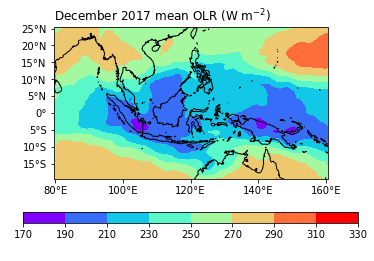

In [19]:
# 繪圖：開啟繪圖空間與地圖設定。
plt.figure()                   # 利用matplotlib開啟畫布。
proj = ccrs.PlateCarree()      # 採用等距地圖投影。
ax = plt.axes(projection=proj) # 設定地圖座標軸。
ax.set_xticks(np.arange(80,180,20), crs=proj)
ax.set_yticks(np.arange(-25,30,5), crs=proj)   # 設定x, y座標的範圍，以及多少經緯度繪製刻度。
lon_formatter = LONGITUDE_FORMATTER
lat_formatter = LATITUDE_FORMATTER   
ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter)  # 將經緯度以degN, degE的方式表示。
ax.coastlines()                # 繪製地圖海岸線。

clevs = np.arange(170,350,20)

# 繪圖
plt.title("December 2017 mean OLR (W m$^{-2}$)", loc='left')    # 設定圖片標題，並且置於圖的左側。
olrPlot = (olrm.plot.contourf("lon",              # 設定x坐標。
                              "lat",              # 設定y坐標。
                              levels=clevs,       # 設定圖例色階間距。
                              cmap='rainbow',     # 設定色階
                              add_colorbar=True,  # 繪製色階。
                              cbar_kwargs={'orientation': 'horizontal', 'aspect': 30, 'label': ' '}) #設定color bar
                              )
                              
ax.set_ylabel(' ')             # 設定坐標軸名稱。
ax.set_xlabel(' ')
plt.show()
#plt.savefig("olr_mean_201712.png", dpi=600)  # 儲存圖片。

計算氣候場及距平值
---
進行氣候分析時，最常從分析**氣候場 (Climatology)** 和**距平值 (Anomaly)** 開始。

**1. 利用`groupby`計算氣候平均：** 由於我們的時間格式是`datetime`，`groupby`可以把相同時間單位的資料整理在一起。例如在計算日氣候場時，運用 `xarray.DataArray.groupby('time.dayofyear')`，就會把各年同一天 (day of year)的資料整理在一起，只要再加上`mean("time")`就會將各年同一天平均起來，得到氣候場。

In [6]:
olrlt = (olr_ds.sel(time=slice('1998-01-01','2017-12-31'),
                    lat=slice(lats,latn),
                    lon=slice(lon1,lon2)).olr)
olrGB = olrlt.groupby("time.dayofyear")
olrDayClim = olrGB.mean("time")
olrDayClim

<xarray.DataArray 'olr' (dayofyear: 366, lat: 46, lon: 82)>
array([[[276.57016, 277.6621 , 278.61517, ..., 265.31964, 261.39734,
         257.30255],
        [272.74466, 274.67706, 276.55304, ..., 263.08496, 259.9906 ,
         258.64532],
        [270.42786, 273.2181 , 275.7293 , ..., 264.6833 , 263.02875,
         260.01642],
        ...,
        [269.25763, 268.24063, 268.32397, ..., 279.23   , 280.48175,
         282.50314],
        [265.09265, 264.08142, 263.65085, ..., 274.46606, 274.73358,
         276.1823 ],
        [261.11285, 259.64722, 259.19257, ..., 268.37277, 268.52383,
         269.89484]],

       [[267.61884, 270.19232, 271.34644, ..., 269.5705 , 266.83807,
         264.5412 ],
        [266.1554 , 269.8971 , 274.43747, ..., 267.21915, 267.25204,
         264.57504],
        [265.53793, 270.52356, 273.5298 , ..., 265.25482, 266.05234,
         262.7517 ],
...
        [273.62296, 275.79193, 276.6615 , ..., 274.614  , 275.36578,
         275.84967],
        [265.16495, 266.59903, 270.0503 , ..., 271.32217, 269.7754 ,
         269.26666],
        [257.74567, 257.30585, 259.72327, ..., 267.25128, 266.76926,
         266.2446 ]],

       [[284.1527 , 284.4728 , 284.53824, ..., 239.93025, 235.14188,
         226.32022],
        [277.27057, 275.72446, 276.3836 , ..., 243.07681, 234.57312,
         230.18576],
        [268.37372, 266.95282, 269.9864 , ..., 244.10503, 233.00247,
         229.0898 ],
        ...,
        [254.57224, 253.15422, 256.98022, ..., 276.0589 , 275.33664,
         273.9538 ],
        [250.69583, 250.74333, 251.67773, ..., 271.11142, 269.65924,
         270.06024],
        [249.83472, 247.60262, 245.02779, ..., 260.52228, 262.07358,
         262.0086 ]]], dtype=float32)
Coordinates:
  * lon        (lon) float32 79.5 80.5 81.5 82.5 ... 157.5 158.5 159.5 160.5
  * lat        (lat) float32 -19.5 -18.5 -17.5 -16.5 ... 22.5 23.5 24.5 25.5
  * dayofyear  (dayofyear) int64 1 2 3 4 5 6 7 8 ... 360 361 362 363 364 365 366

從以上輸出的結果，可以看到 `olrDayClim` 有一個`dayofyear`的坐標軸，範圍為1 ... 366。

**2.** 有了氣候場，也可以很方便地計算距平場。

In [7]:
olra = olr.groupby('time.dayofyear') - olrDayClim 
olra 

<xarray.DataArray 'olr' (time: 31, lat: 46, lon: 82)>
array([[[ 14.365967  ,  15.518036  ,  12.919525  , ..., -57.476517  ,
         -75.543594  , -69.234924  ],
        [ 20.06195   ,  18.835693  ,  17.135101  , ..., -57.605713  ,
         -64.172     , -53.574966  ],
        [ 22.144684  ,  20.983612  ,  20.10431   , ..., -52.231903  ,
         -54.484116  , -58.276245  ],
        ...,
        [ 11.885345  ,  13.526215  ,  11.7430725 , ...,  22.446533  ,
          25.207245  ,  28.938232  ],
        [ 15.636475  ,  18.244537  ,  12.468475  , ...,  21.97882   ,
          26.347961  ,  27.00003   ],
        [ 15.356995  ,  16.64682   ,  17.843414  , ...,  24.412567  ,
          25.322144  ,  26.76233   ]],

       [[ 10.291229  ,  11.276459  ,  10.495972  , ...,   7.371765  ,
           3.7930298 , -11.360138  ],
        [ 17.786621  ,  17.12024   ,  15.492889  , ...,  17.815125  ,
          -9.014236  , -18.782898  ],
        [ 28.262085  ,  27.283356  ,  22.516937  , ...,  25.389648  ,
          -5.069626  , -17.442474  ],
...
        [ -2.648407  ,  -3.5192566 ,  -2.7421875 , ..., -26.07492   ,
         -18.371887  ,  -5.643799  ],
        [  1.5956726 ,  -0.43017578,  -1.156189  , ..., -26.547653  ,
         -23.771393  , -16.572845  ],
        [  8.186066  ,   4.232605  ,  -0.51535034, ..., -18.047714  ,
         -16.96135   , -18.252182  ]],

       [[ 16.307556  ,  25.0018    ,  25.530853  , ...,  -6.391388  ,
           8.152954  ,   5.15744   ],
        [ 23.00055   ,  27.799072  ,  26.880829  , ...,  -4.4205933 ,
          11.356567  ,  13.310394  ],
        [ 25.283844  ,  28.208221  ,  26.902557  , ...,   7.470764  ,
          18.606049  ,  24.229614  ],
        ...,
        [ -1.696167  ,  -1.6689758 ,  -2.5436707 , ...,  -9.529449  ,
         -21.949661  , -24.307999  ],
        [  3.8825989 ,   3.7442627 ,   2.6192627 , ...,   4.5918884 ,
          -0.2866211 ,  -9.932922  ],
        [  9.954926  ,   7.934784  ,   6.7912903 , ...,  20.031525  ,
          22.641785  ,  18.353333  ]]], dtype=float32)
Coordinates:
  * time       (time) datetime64[ns] 2017-12-01 2017-12-02 ... 2017-12-31
  * lon        (lon) float32 79.5 80.5 81.5 82.5 ... 157.5 158.5 159.5 160.5
  * lat        (lat) float32 -19.5 -18.5 -17.5 -16.5 ... 22.5 23.5 24.5 25.5
    dayofyear  (time) int64 335 336 337 338 339 340 ... 360 361 362 363 364 365

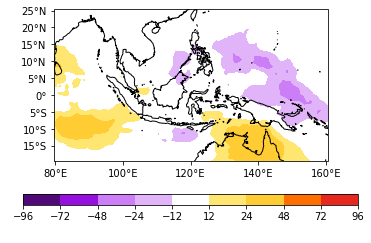

In [8]:
plt.figure()                  
proj = ccrs.PlateCarree()      
ax = plt.axes(projection=proj) 
ax.set_xticks(np.arange(80,180,20), crs=proj)
ax.set_yticks(np.arange(-25,30,5), crs=proj)   
lon_formatter = LONGITUDE_FORMATTER
lat_formatter = LATITUDE_FORMATTER   
ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter)  
ax.coastlines()  

olraPlot = (olra.mean(axis=0)
                .plot.contourf("lon","lat", 
                              levels=[-96,-72,-48,-24,-12,12,24,48,72,96],
                              cmap=cmaps.sunshine_diff_12lev, 
                              add_colorbar=True,
                              cbar_kwargs={'orientation': 'horizontal', 'aspect': 30, 'label': ' '}) 
                              )
ax.set_ylabel(' ')
ax.set_xlabel(' ')
plt.show()

得到的距平場`olra`的時空範圍和`olr`完全一樣。

**Remark:**
Do your spatial and temporal indexing (e.g. ``.sel()`` or ``.isel()``) early in the pipeline, especially before calling `resample()` or `groupby()`. Grouping and resampling triggers some computation on all the blocks, which in theory should commute with indexing, but this optimization hasn’t been implemented in Dask yet. (See [Optimization Tips](https://xarray.pydata.org/en/stable/user-guide/dask.html#optimization-tips)).

**3. 計算「平滑」氣候場：** 平滑氣候場是保留氣候場的前*n*個諧函數 (harmonics)，必須運用傅立葉變換 (fast Fourier transform, FFT) 計算。計算FFT需要用到`scipy`函式庫。然而由於`scipy`目前尚不支援`xarray.DataArray`，因此必須先轉換成`numpy.ndarray`才能進行FFT運算，或是利用[`xrft` (Fourier transforms for xarray data)](https://xrft.readthedocs.io/en/latest/)模組。下列程式碼`smthClmDay`函數和NCL完全一樣。

In [9]:
from scipy.fft import rfft, irfft

def smthClmDay(clmDay, nHarm):
    cf = rfft(clmDay.values, axis=0)     # xarray.DataArray.values 可將DataArray 轉換成numpy.ndarray。
    cf[nHarm,:,:] = 0.5*cf[nHarm,:,:]    # mini-taper.
    cf[nHarm+1:,:,:] = 0.0               # set all higher coef to 0.0
    icf = irfft(cf, axis=0)              # reconstructed series
    clmDaySmth = xr.DataArray(
                 data=icf,
                 dims=["dayofyear", "lat", "lon"],
                 coords=dict(
                            lon = clmDay.lon,
                            lat = clmDay.lat,
                            dayofyear = clmDay.dayofyear,
                            ),
                 attrs=dict(
                            information = "Smoothed daily climatological averages",
                            smoothing   = "FFT: "+str(nHarm)+" harmonics were retained."
                           ),
                  )
    return(clmDaySmth)

olrDayClim_sm = smthClmDay(olrDayClim, 3) 
olrDayClim_sm

<xarray.DataArray (dayofyear: 366, lat: 46, lon: 82)>
array([[[274.67673, 274.98502, 275.11856, ..., 262.0068 , 261.17316,
         260.1343 ],
        [273.3904 , 273.20236, 273.56137, ..., 259.84003, 259.2469 ,
         258.30975],
        [271.12125, 271.22818, 271.74142, ..., 257.19107, 256.08743,
         255.12474],
        ...,
        [272.81976, 272.87732, 273.01465, ..., 277.80392, 278.28287,
         278.68033],
        [270.07288, 270.16125, 270.45535, ..., 273.1664 , 273.5746 ,
         274.071  ],
        [266.303  , 266.56897, 267.01465, ..., 267.88696, 268.36902,
         268.74802]],

       [[274.53384, 274.84183, 274.97333, ..., 261.7166 , 260.89746,
         259.8728 ],
        [273.23807, 273.0441 , 273.39777, ..., 259.50763, 258.94028,
         258.03616],
        [270.9595 , 271.06064, 271.56778, ..., 256.81567, 255.74944,
         254.81166],
...
        [273.48935, 273.5425 , 273.67438, ..., 278.09503, 278.57452,
         278.97787],
        [270.78375, 270.89615, 271.23215, ..., 273.45703, 273.87363,
         274.37927],
        [267.08844, 267.38306, 267.85352, ..., 268.14432, 268.6342 ,
         269.03677]],

       [[274.81702, 275.12543, 275.26138, ..., 262.2972 , 261.4488 ,
         260.39554],
        [273.53967, 273.3582 , 273.7226 , ..., 260.17154, 259.55222,
         258.5823 ],
        [271.2799 , 271.39307, 271.9124 , ..., 257.5647 , 256.42377,
         255.43636],
        ...,
        [273.14917, 273.20532, 273.3404 , ..., 277.9489 , 278.42838,
         278.82898],
        [270.42175, 270.5226 , 270.83813, ..., 273.31055, 273.72305,
         274.22427],
        [266.6878 , 266.96854, 267.42728, ..., 268.01395, 268.5    ,
         268.89093]]], dtype=float32)
Coordinates:
  * lon        (lon) float32 79.5 80.5 81.5 82.5 ... 157.5 158.5 159.5 160.5
  * lat        (lat) float32 -19.5 -18.5 -17.5 -16.5 ... 22.5 23.5 24.5 25.5
  * dayofyear  (dayofyear) int64 1 2 3 4 5 6 7 8 ... 360 361 362 363 364 365 366
Attributes:
    information:  Smoothed daily climatological averages
    smoothing:    FFT: 3 harmonics were retained.

選取澳洲季風區，繪製氣候的時序圖。

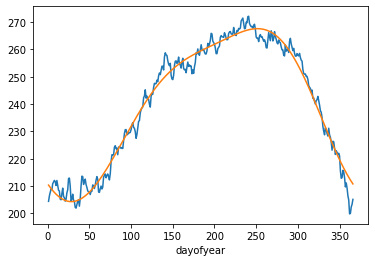

In [10]:
plt.figure()                   
(olrDayClim.sel(lon=slice(115,150),lat=slice(-15,-2))
          .mean(["lat","lon"])
          .plot.line(x="dayofyear"))
(olrDayClim_sm.sel(lon=slice(115,150),lat=slice(-15,-2))
              .mean(["lat","lon"])
              .plot.line(x="dayofyear"))
plt.show()

上圖藍線的部分為原始的氣候場，橘線的部分則是保留前三個諧函數的氣候場，縱軸為OLR，橫軸則是一年之中的天數。

時間條件控制
---
在先前的範例中，已經示範如何用`slice`來選擇特定時間區間的資料，但若選擇的時間並不連續，用`slice`就不太方便。因此若能在時間加入一些條件控制，則可以只選擇滿足條件的資料。

**Example 3: 選擇JAS季節的資料** 
由於檔案標準時間格式為`datetime64`物件，這樣的物件會自動解析時間的年、月、日、時、分、秒等（還有其他可控制的項目）。以選擇JAS 七八九月為例

In [11]:
olr_jas = olrlt.sel(time=(olrlt.time.dt.month.isin([7,8,9]))) 
olr_jas

<xarray.DataArray 'olr' (time: 1840, lat: 46, lon: 82)>
[6940480 values with dtype=float32]
Coordinates:
  * time     (time) datetime64[ns] 1998-07-01 1998-07-02 ... 2017-09-30
  * lon      (lon) float32 79.5 80.5 81.5 82.5 83.5 ... 157.5 158.5 159.5 160.5
  * lat      (lat) float32 -19.5 -18.5 -17.5 -16.5 -15.5 ... 22.5 23.5 24.5 25.5
Attributes:
    standard_name:  toa_outgoing_longwave_flux
    long_name:      NOAA Climate Data Record of Daily Mean Upward Longwave Fl...
    units:          W m-2
    cell_methods:   time: mean area: mean

**Example 4: 移除閏日 (leap day)**
利用類似Example 3的方法，也可以只選取2/29之外的其他日期 (反向選擇)，而達到移除閏日的目的。

In [12]:
olr_noleap = olrlt.sel(time=~((olrlt.time.dt.month == 2) & (olrlt.time.dt.day == 29)))  # ~() 代表反向選擇
olr_noleap

<xarray.DataArray 'olr' (time: 7300, lat: 46, lon: 82)>
[27535600 values with dtype=float32]
Coordinates:
  * time     (time) datetime64[ns] 1998-01-01 1998-01-02 ... 2017-12-31
  * lon      (lon) float32 79.5 80.5 81.5 82.5 83.5 ... 157.5 158.5 159.5 160.5
  * lat      (lat) float32 -19.5 -18.5 -17.5 -16.5 -15.5 ... 22.5 23.5 24.5 25.5
Attributes:
    standard_name:  toa_outgoing_longwave_flux
    long_name:      NOAA Climate Data Record of Daily Mean Upward Longwave Fl...
    units:          W m-2
    cell_methods:   time: mean area: mean

沒有2/29的資料。

手動創建DataArray
---
從讀取netCDF檔案的過程中，我們已經理解DataArray的架構，也就是將資料儲存在座標軸的框架中，其中大氣科學資料的儲存格式大多是(time, level, lat, lon)這樣四維的結構。當然，也不一定要是這四個軸，只要是給定了座標軸，我們就可以手動建立DataArray。

**Example 5a: 將每日OLR資料轉化成(year, pentad, lat, lon)格式：** 在探討季內尺度的季內變異時，將資料轉換成pentad單位是很方便的做法，可以過濾掉太高頻天氣尺度的變化。

In [13]:
olr_ptd = xr.DataArray( 
                       dims=['year','pentad','lat','lon'],
                       coords=dict(year=range(1998,2018), 
                                   pentad=range(1,74),
                                   lat=olrlt.lat,
                                   lon=olrlt.lon))
for yy in olr_ptd.year: 
    for p in olr_ptd.pentad:
        olr_ptd.loc[yy,p,:,:] = (olrlt[ int((yy-1998)*365+ (p-1)*5) : int((yy-1998)*365+ (p-1)*5 + 14),:,:  ]
                                      .mean(axis=0))
olr_ptd

<xarray.DataArray (year: 20, pentad: 73, lat: 46, lon: 82)>
array([[[[267.05123901, 265.95581055, 269.9135437 , ..., 247.70814514,
          253.29109192, 259.49972534],
         [271.3041687 , 270.94281006, 273.71734619, ..., 236.05064392,
          244.63224792, 250.59677124],
         [270.94784546, 272.96466064, 275.90234375, ..., 224.07041931,
          234.97497559, 235.66764832],
         ...,
         [262.08236694, 262.27474976, 263.85708618, ..., 289.10122681,
          288.85494995, 288.28427124],
         [258.17068481, 260.63827515, 259.81072998, ..., 285.44549561,
          283.46130371, 284.04437256],
         [255.37953186, 254.53831482, 256.34332275, ..., 282.36569214,
          280.33987427, 279.62954712]],

        [[263.92288208, 261.60928345, 264.16168213, ..., 240.89450073,
          244.41609192, 251.52470398],
         [268.73126221, 266.84616089, 268.7739563 , ..., 233.46354675,
          238.81794739, 242.12924194],
         [265.58926392, 266.27749634, 269.64657593, ..., 229.64537048,
          235.54354858, 234.00830078],
...
         [274.10101318, 274.4211731 , 274.34228516, ..., 285.51928711,
          284.70361328, 287.84640503],
         [272.17242432, 273.49151611, 273.74169922, ..., 283.30841064,
          284.0211792 , 283.05230713],
         [267.37356567, 268.75640869, 271.84249878, ..., 280.16201782,
          281.25881958, 281.04986572]],

        [[287.89074707, 290.42541504, 291.79898071, ..., 280.05499268,
          282.7953186 , 275.63006592],
         [290.07519531, 290.30084229, 289.65975952, ..., 283.09436035,
          283.10592651, 279.95965576],
         [290.07739258, 289.65560913, 289.32717896, ..., 286.71871948,
          284.76565552, 282.81054688],
         ...,
         [278.53997803, 278.69451904, 278.02154541, ..., 275.07791138,
          276.17852783, 280.68807983],
         [277.16772461, 277.60903931, 277.53286743, ..., 275.27804565,
          274.6953125 , 273.52435303],
         [274.71694946, 273.08502197, 272.38876343, ..., 274.17181396,
          276.41027832, 275.20233154]]]])
Coordinates:
  * year     (year) int64 1998 1999 2000 2001 2002 ... 2013 2014 2015 2016 2017
  * pentad   (pentad) int64 1 2 3 4 5 6 7 8 9 10 ... 65 66 67 68 69 70 71 72 73
  * lat      (lat) float32 -19.5 -18.5 -17.5 -16.5 -15.5 ... 22.5 23.5 24.5 25.5
  * lon      (lon) float32 79.5 80.5 81.5 82.5 83.5 ... 157.5 158.5 159.5 160.5

常用的運算與統計方法
---
### 1. 網格內插 (Interpolation)

不同的資料通常有不同的時間和網格解析度，根據需求有時需要將資料`A`資料內插到資料`B`的網格上。`xarray.DataArray` 和`xarray.Dataset` 有內建網格內插的方法，請見以下範例。

**Example 6:** GPCP降雨資料網格解析度為2.5度，OLR網格資料解析度為1度，欲將OLR資料內插到GPCP資料網格上。

In [14]:
with xr.open_dataset('data/gpcp_precip_1979-2019.pentad.nc') as pcp_ds: 
    pcp = pcp_ds.sel(lat=slice(latn,lats), lon=slice(lon1,lon2)).data

olr_rmp = olr.interp(lon=pcp.lon, lat=pcp.lat)   # 利用interp的method進行網格內插。
olr_rmp

<xarray.DataArray 'olr' (time: 31, lat: 20, lon: 32)>
array([[[290.77692, 290.39453, 295.43213, ..., 296.81284, 301.36624,
         308.5393 ],
        [279.31198, 292.2012 , 296.87137, ..., 292.30505, 299.59418,
         305.23346],
        [288.23547, 298.7001 , 308.13608, ..., 302.51755, 302.13452,
         305.7267 ],
        ...,
        [291.722  , 291.32483, 290.13385, ..., 274.74713, 235.51575,
         203.51103],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan]],

       [[271.99097, 277.9667 , 285.51022, ..., 285.6931 , 293.7487 ,
         300.43378],
        [288.28772, 289.44183, 290.90607, ..., 288.88275, 294.53885,
         302.5985 ],
        [287.5372 , 293.159  , 300.6352 , ..., 295.86868, 303.03174,
         306.88895],
...
        [292.338  , 288.28302, 284.37592, ..., 286.02167, 286.85507,
         294.8603 ],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan]],

       [[273.61133, 273.96576, 273.2109 , ..., 292.70874, 283.15085,
         265.2025 ],
        [283.28424, 277.60345, 268.70056, ..., 273.03506, 266.82367,
         264.57874],
        [279.25763, 265.31638, 230.47275, ..., 277.5205 , 284.12512,
         289.86246],
        ...,
        [301.16412, 294.547  , 286.20282, ..., 242.08144, 251.92857,
         262.99533],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan]]], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 2017-12-01 2017-12-02 ... 2017-12-31
  * lon      (lon) float32 81.25 83.75 86.25 88.75 ... 151.2 153.8 156.2 158.8
  * lat      (lat) float32 23.75 21.25 18.75 16.25 ... -18.75 -21.25 -23.75
Attributes:
    standard_name:  toa_outgoing_longwave_flux
    long_name:      NOAA Climate Data Record of Daily Mean Upward Longwave Fl...
    units:          W m-2
    cell_methods:   time: mean area: mean

### 2. 改變網格解析度：
時間和空間的網格解析度可以用採用 `xarray.DataArray.coarsen` 更改。

**Example 5b:** 將每日OLR轉換成侯(pentad)平均資料，意即將時間解析度調整為5天一次。

In [16]:
olr_ptd = (olr_noleap.coarsen(time=5,
                              coord_func={"time": "min"})  
                     .mean())
olr_ptd

<xarray.DataArray 'olr' (time: 1460, lat: 46, lon: 82)>
array([[[284.27383, 285.73615, 288.25266, ..., 231.88799, 241.6569 ,
         249.84024],
        [286.65228, 288.0508 , 288.27435, ..., 215.95383, 230.82944,
         246.1481 ],
        [290.7838 , 290.2586 , 287.82904, ..., 198.27681, 214.98921,
         225.9622 ],
        ...,
        [258.53317, 257.85672, 261.8361 , ..., 292.9726 , 292.6562 ,
         291.6869 ],
        [256.71277, 259.9763 , 260.89008, ..., 289.4385 , 286.21698,
         287.22504],
        [256.16098, 251.98056, 256.90253, ..., 286.82864, 283.24362,
         283.8355 ]],

       [[257.097  , 249.0689 , 260.7727 , ..., 251.24785, 258.4394 ,
         267.57504],
        [265.49664, 263.9062 , 270.4431 , ..., 237.29636, 248.2174 ,
         250.10226],
        [261.7508 , 266.22888, 276.74783, ..., 222.4416 , 235.64157,
         227.53247],
...
        [269.66202, 270.14777, 270.66302, ..., 295.96063, 293.2287 ,
         295.0047 ],
        [267.17712, 269.37402, 269.95056, ..., 291.3388 , 293.34708,
         292.58026],
        [260.03018, 264.42783, 271.2962 , ..., 286.15222, 286.1073 ,
         286.89746]],

       [[287.89075, 290.4254 , 291.79898, ..., 280.055  , 282.79532,
         275.63007],
        [290.0752 , 290.30084, 289.65976, ..., 283.09436, 283.10593,
         279.95966],
        [290.0774 , 289.6556 , 289.32718, ..., 286.71872, 284.76566,
         282.81055],
        ...,
        [278.53998, 278.69452, 278.02155, ..., 275.0779 , 276.17853,
         280.68808],
        [277.16772, 277.60904, 277.53287, ..., 275.27805, 274.6953 ,
         273.52435],
        [274.71695, 273.08502, 272.38876, ..., 274.1718 , 276.41028,
         275.20233]]], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 1998-01-01 1998-01-06 ... 2017-12-27
  * lon      (lon) float32 79.5 80.5 81.5 82.5 83.5 ... 157.5 158.5 159.5 160.5
  * lat      (lat) float32 -19.5 -18.5 -17.5 -16.5 -15.5 ... 22.5 23.5 24.5 25.5
Attributes:
    standard_name:  toa_outgoing_longwave_flux
    long_name:      NOAA Climate Data Record of Daily Mean Upward Longwave Fl...
    units:          W m-2
    cell_methods:   time: mean area: mean

也就是在時間的維度上，5天為一個單位平均。 `coord_func` 預設為 `mean`，也就是重新取樣後的座標 (時間) 軸會選擇5天平均後的時間軸 (如1998-01-03, 1998-01-08, 1998-01-13, ...)，其他選項可選 `min` 設定為最小值 (一侯的開始日) 或 `max` 最大值 (一侯的結束日)。

**Note:** 雖然`xarray.DataArray.resample`看似也有同樣功能，但根據API reference，
> The resampled dimension must be a datetime-like coordinate.

根據以上範例，就是 `pcp_ptd = pcp_noleap.resample(time='5D')` ，然而`datetime` 物件無法選擇日曆格式，也就是在計算五天平均時，不論原始資料 `pcp_noleap` 有沒有2/29，這個方法都會納入2/29 (延伸閱讀：[StackOverflow 的問答](https://stackoverflow.com/questions/64476727/can-we-assign-the-calendar-of-pandas-datetimeindex-as-noleap-or-can-datetime))。

### 3. 滑動平均 (running mean)：
可利用 `xarray.DataArray.rolling`，連續選擇3個單位，再進行平均。

In [17]:
olr_3p_runave = (olr_ptd.rolling(time=3,        # 選擇幾個時間單位
                                 center=False)
                        .mean())
olr_3p_runave

<xarray.DataArray 'olr' (time: 1460, lat: 46, lon: 82)>
array([[[         nan,          nan,          nan, ...,          nan,
                  nan,          nan],
        [         nan,          nan,          nan, ...,          nan,
                  nan,          nan],
        [         nan,          nan,          nan, ...,          nan,
                  nan,          nan],
        ...,
        [         nan,          nan,          nan, ...,          nan,
                  nan,          nan],
        [         nan,          nan,          nan, ...,          nan,
                  nan,          nan],
        [         nan,          nan,          nan, ...,          nan,
                  nan,          nan]],

       [[         nan,          nan,          nan, ...,          nan,
                  nan,          nan],
        [         nan,          nan,          nan, ...,          nan,
                  nan,          nan],
        [         nan,          nan,          nan, ...,          nan,
                  nan,          nan],
...
        [261.09159342, 264.46543376, 264.40606689, ..., 289.98061117,
         289.84018962, 290.62229411],
        [259.26981608, 261.28741455, 263.61486816, ..., 284.35563151,
         286.77596029, 286.33197021],
        [255.4124349 , 258.82198079, 262.70076497, ..., 279.19376628,
         280.51509603, 280.38521322]],

       [[288.55529785, 289.70176188, 288.92041016, ..., 282.8608195 ,
         283.66341146, 281.8024292 ],
        [286.7039388 , 287.58215332, 286.75150553, ..., 283.03340658,
         282.0999349 , 279.72692871],
        [283.25203451, 283.78063965, 285.37109375, ..., 282.98014323,
         280.22558594, 279.6295166 ],
        ...,
        [262.41918945, 265.33905029, 264.62530518, ..., 287.96309408,
         287.44110107, 289.45731608],
        [261.0460612 , 263.0098877 , 264.46313477, ..., 285.03059896,
         286.25012207, 284.89621989],
        [256.97867839, 259.36291504, 262.22611491, ..., 281.74800618,
         282.45597331, 282.41038005]]])
Coordinates:
  * time     (time) datetime64[ns] 1998-01-01 1998-01-06 ... 2017-12-27
  * lon      (lon) float32 79.5 80.5 81.5 82.5 83.5 ... 157.5 158.5 159.5 160.5
  * lat      (lat) float32 -19.5 -18.5 -17.5 -16.5 -15.5 ... 22.5 23.5 24.5 25.5
Attributes:
    standard_name:  toa_outgoing_longwave_flux
    long_name:      NOAA Climate Data Record of Daily Mean Upward Longwave Fl...
    units:          W m-2
    cell_methods:   time: mean area: mean

由於頭尾會有缺失值NaN，可加上`dropna()`移除之。